<p>In this file we import our dataset, convert text data into numerical data, perform dimension reduction and evaluate performance of each dimension reduction technique used</p>

For evaluation we fit Logistic Regression model using our data. The Logitic Regression Model is defined as:\
**Solver = Limited-memory Broyden-Fletcher-Goldfarb-Shanno**\
**Penalty = L2 Penalty**\
**Tolerance = 0.0001**\
**Regularization Strength = 1**\
**No class weights are provided**

Variables and their meaning:\
**model -> stores instances of classification model**\
**X -> 0-1 matrix corresponding to data in dataset. Generated using CountVectoriser**\
**Y -> True-Fasle matrix corresponding to label for each data point**\
**reduced_X -> result of performing dimension reduction on X**\

<h1>Import Libraries</h1>

In [1]:
# Numpy Library for Numerical Calculations
import numpy as np

# Pandas Library for Dataframe
import pandas as pd

# Matplotlib and for Plottings
import matplotlib.pyplot as plt

# Pickle Library for Saving the Model
import pickle

# RE Library for Regular Expression
import re

# NLTK Library for Natural Language Processing
import nltk
# Downloading the Stopwords
# nltk.download('stopwords') 

# Stopwords for removing stopwords in the Text
from nltk.corpus import stopwords

# PorterStemmer for Stemming the Words
from nltk.stem.porter import PorterStemmer

# CountVectorizer for Bagging of Words and Vectorizing it
from sklearn.feature_extraction.text import CountVectorizer

# Train_Test_Split for splitting the Dataset
from sklearn.model_selection import train_test_split

# Accuracy Score, F1 Score and Confusion Matrix is for Analysis of Models
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

# Import Principal Component Analysis for dimension reduction
from sklearn.decomposition import PCA

# Import T-Distributed Stochastic Neighbour Embedding for dimension reduction
from sklearn.manifold import TSNE

# Import other libraries for dimension reduction
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold

# Import Logistic Regression Model
from sklearn.linear_model import LogisticRegression

import os

<h1>Defining our model</h1>

In [2]:
model = LogisticRegression()

<h1>Defining Functions</h1>

In [3]:
def visualize_data(data:np.array=None):
    '''
    To visualize high-dimensional data (dim(data) > 50) into 2 dimensional scatter graph
    It uses PCA to first reduce dimension to 50 dimemsions. PCA is used to preserve global linear properties such as
    preserving variance between eigenvectors
    Then tSNE is used to further reduced dimensions from 50 -> 2. tSNE preserves local properties such as distance
    between neighbours

    data: matrix of form n X m where m > 50, represented using np.array
    '''

    if data is None:
        raise Exception("No data provided")
    os.environ['OMP_NUM_THREADS'] = '1'
    
    pca = PCA(n_components=50)
    reduced_data = pca.fit_transform(data)
    
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(reduced_data)
    
    for label in np.unique(Y):
        plt.scatter(reduced_data[Y == label, 0], reduced_data[Y == label, 1], 
                    label='Ham' if label == 0 else 'Spam', alpha=0.3)
    
    plt.legend()
    plt.title("t-SNE Visualization of Spam vs Ham Messages")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

In [4]:
def evaluate_model(model=None, metric:str='both', is_split:bool=True, train_set:tuple=None, test_set:tuple=None):
    '''
    This function performs prediction and print evaluation of predicition
    
    model: instance of a fitted model
    
    metric: string corresponding to metric to be calculated.
            'both' means to compute accuracy and f1 score 
            'accuracy' means to compute accuracy only
            'f1' means to compute f1 only
            
    is_split: bool value to tell if data is split into train and test set
                True means that data is split
                False means that data is not splitted
                
    train_set: tuple value which contains both train dataset at 0th position and corresponding labels at 1st position
                in the form np.array
                If is_split is False, then train_set is assumed to contain dataset and corresponding label

    test_set: tuple value which contains both train dataset at 0th position and corresponding labels at 1st position
                in the form np.array
    '''
    
    if model is None:
        raise Exception("No Model Provided")
    
    if is_split and (train_set is not None and test_set is not None):
        prediction_train = model.predict(train_set[0])
        prediction_test = model.predict(test_set[0])
        
        if (metric == 'both'):
            accuracy_train = accuracy_score(train_set[1], prediction_train)
            f1_train = f1_score(train_set[1], prediction_train)
            
            accuracy_test = accuracy_score(test_set[1], prediction_test)
            f1_test = f1_score(test_set[1], prediction_test)
            
            print(f"Accuracy on train data is: {accuracy_train*100:.2f}")
            print(f"Accuracy on test data is: {accuracy_test*100:.2f}")
            
            print(f"F1 score on train data is: {f1_train:.2f}")
            print(f"F1 score on test data is: {f1_test:.2f}")
        
        elif (metric == 'accuracy'):
            accuracy_train = accuracy_score(train_set[1], prediction_train)      
            accuracy_test = accuracy_score(test_set[1], prediction_test)
            
            print(f"Accuracy on train data is: {accuracy_train*100:.2f}")
            print(f"Accuracy on test data is: {accuracy_test*100:.2f}")
            
        elif (metric == 'f1'):
            f1_train = f1_score(train_set[1], prediction_train)
            f1_test = f1_score(test_set[1], prediction_test)
            
            print(f"F1 score on train data is: {f1_train:.2f}")
            print(f"F1 score on test data is: {f1_test:.2f}")
    else:
        prediction = model.predict(train_set[0])
        
        if (metric == 'both'):
            accuracy = accuracy_score(train_set[1], prediction)
            f1 = f1_score(train_set[1], prediction)
            
            print(f"Accuracy on train data is: {accuracy*100:.2f}")       
            print(f"F1 score on train data is: {f1:.2f}")
        
        elif (metric == 'accuracy'):
            accuracy = accuracy_score(train_set[1], prediction)         
            print(f"Accuracy on train data is: {accuracy*100:.2f}")
            
        elif (metric == 'f1'):
            f1 = f1_score(train_set[1], prediction)
            print(f"F1 score on train data is: {f1:.2f}")

In [83]:
def generate_confusion_matrix(data:np.array=None, labels:np.array=None, model=None):

    '''
    To print and display confusion matrix

    data: matrix corresponding to dataset

    labels: matrix corresponding to labels of each datapoint

    model: instance of a fitted model
    '''

    if model is None:
        raise Exception("No Model provided")

    if data is None or labels is None:
        raise Exception("Either data or label or both are not provided")
        
    prediction = model.predict(data)
    tn, fp, fn, tp = confusion_matrix(list(labels), list(prediction), labels=[False, True]).ravel()
 
    print('True Positive', tp)
    print('True Negative', tn)
    print('False Positive', fp)
    print('False Negative', fn)
     
    ConfusionMatrixDisplay.from_predictions(labels, prediction)
    plt.show()

<h1>Importing Data and Data Pre-processing</h1>

<h2>Import Data</h2>

In [6]:
# Read the dataset in file "spam.csv". Downloaded from Kaggle -> https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
# Link to original dataset -> https://archive.ics.uci.edu/dataset/228/sms+spam+collection
# Credit to authors of original dataset: Almeida, T. & Hidalgo, J. (2011). SMS Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5CC84.
spam = pd.read_csv("spam.csv", encoding='ISO-8859-1')

In [7]:
spam

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [8]:
spam = spam[['v1', 'v2']]
spam.columns = ['label', 'message']
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
spam.shape

(5572, 2)

In [10]:
spam.groupby('label').size()

label
ham     4825
spam     747
dtype: int64

<h2>Convert Text Messages to Numerical Data</h2>

<h3>Porter Stemming and Data Cleanup</h3>

<p>Porter Stemming removes suffixes from words in English. Example: cats -> cat; agreed -> agree; failing -> fail</p>

<p>Removing non-alphabet symbols from messages, Converting all symbols to lower-case</p>

In [11]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(spam)):
    review = re.sub('[^a-zA-Z]', ' ', spam['message'][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [12]:
for idx in range(6):
    print(f"Before Porter Stemming: {spam['message'][idx]}")
    print(f"After Porter Stemming: {corpus[idx]}")
    print("\n")

Before Porter Stemming: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
After Porter Stemming: go jurong point crazi avail bugi n great world la e buffet cine got amor wat


Before Porter Stemming: Ok lar... Joking wif u oni...
After Porter Stemming: ok lar joke wif u oni


Before Porter Stemming: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
After Porter Stemming: free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli


Before Porter Stemming: U dun say so early hor... U c already then say...
After Porter Stemming: u dun say earli hor u c alreadi say


Before Porter Stemming: Nah I don't think he goes to usf, he lives around here though
After Porter Stemming: nah think goe usf live around though


Before Porter Stemming: FreeMsg Hey there darling it's been 3 week's now 

<h3>Converting cleaned data into numerical form using Count Vectorizer</h3>

<p>Creates a matrix where row corresponds to messages and columns corresponds to unique words in the collection of messages. If element at ith row and jth columns is 0, then it means that ith message does not have word corresponding to jth column and if it is 1, then it means that ith message has a word corresponding to jth column. Let X correspond to this matrix</p>

<p>Also, create a matrix of size number_of_message x 1 corresponding to label associated with each message and let Y is that matrix. Y is a true-false matrix where True -> Spam and False -> Ham</p>

In [13]:
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
Y = pd.get_dummies(spam['label'])
Y = Y.iloc[:, 1].values

<h2>Visualising Data</h2>

In [14]:
print(f"Number of Data points, n = {len(X)}")
print(f"Number of Features, p = {len(X[1])}")

Number of Data points, n = 5572
Number of Features, p = 6221


<h3>Visualising X</h3>

In [15]:
pd.DataFrame(X, columns=cv.get_feature_names_out())

,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zero,zf,zhong,zindgi,zoe,zogtoriu,zoom,zouk,zs,zyada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3>Visualising Data in two dimension</h3>

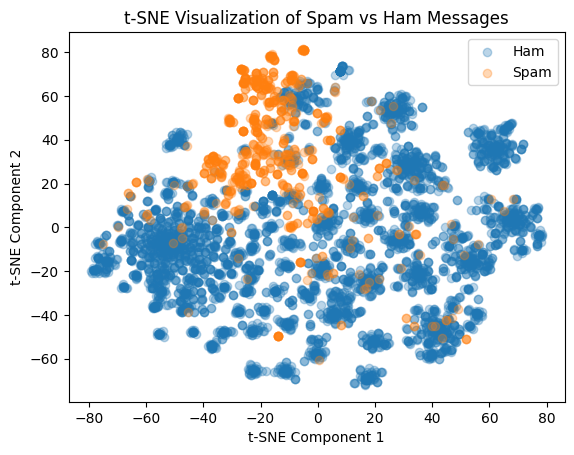

In [16]:
visualize_data(X)

<h2>Training and Evaluating Model</h2>

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

In [18]:
model.fit(X_train, Y_train)

LogisticRegression()

In [19]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.64
Accuracy on test data is: 97.76
F1 score on train data is: 0.99
F1 score on test data is: 0.91


<h2>Confusion Matrix for train data</h2>

True Positive 582
True Negative 3859
False Positive 1
False Negative 15


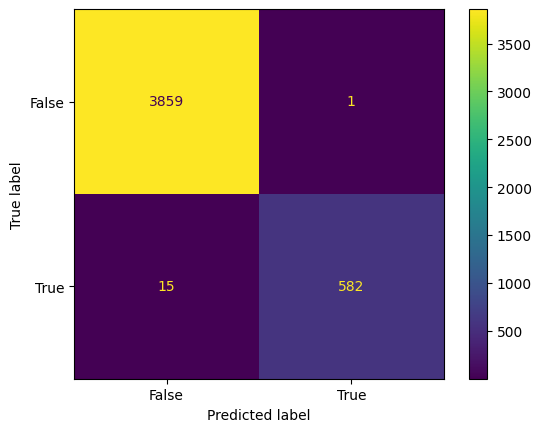

In [20]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h2>Confusion Matrix for test data</h2>

True Positive 125
True Negative 965
False Positive 0
False Negative 25


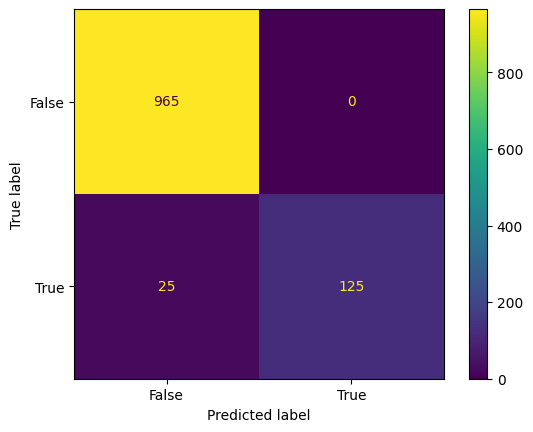

In [21]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h1>Considering only first n features of data</h1>

<h2>Visualizing data</h2>

In [22]:
reduced_X = np.delete(X, np.s_[2000:], 1)

In [23]:
reduced_X.shape

(5572, 2000)

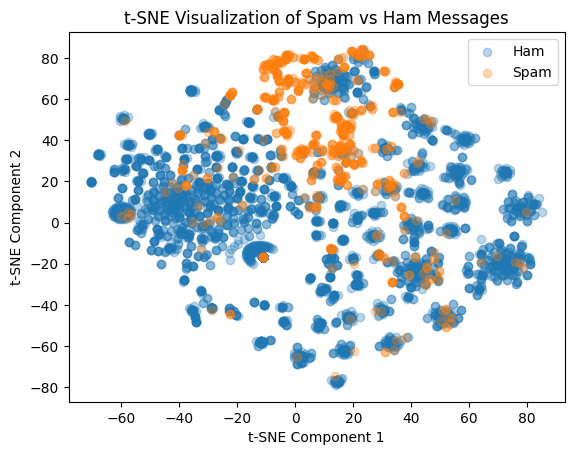

In [24]:
visualize_data(reduced_X)

<h2>Training and Evaluating Model</h2>

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

In [26]:
model.fit(X_train, Y_train)

LogisticRegression()

In [27]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 96.99
Accuracy on test data is: 96.14
F1 score on train data is: 0.88
F1 score on test data is: 0.84


<h2>Plotting our results</h2>

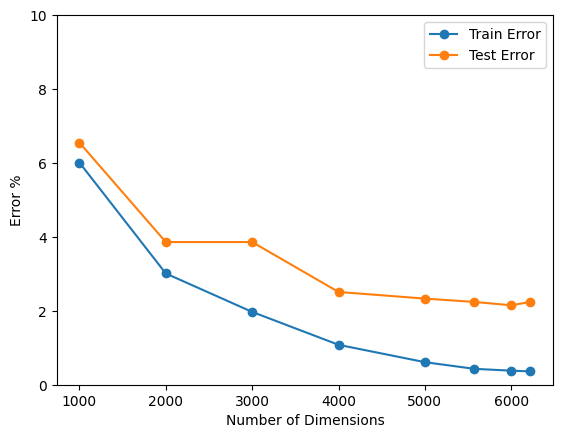

In [28]:
xpoints = np.array([1000,2000,3000,4000,5000,5572,6000,6221])
train_points = np.array([6.01,3.01,1.97,1.08,0.61,0.43,0.38,0.36])
test_points = np.array([6.55,3.86,3.86,2.51,2.33,2.24,2.15,2.24])
plt.xlabel("Number of Dimensions")
plt.ylabel("Error %")

plt.plot(xpoints, train_points, marker='o', label="Train Error")
plt.plot(xpoints, test_points, marker='o', label="Test Error")
plt.ylim(0,10)
plt.legend()
plt.show()

<h2>Confusion Matrix for train data</h2>

True Positive 480
True Negative 3843
False Positive 17
False Negative 117


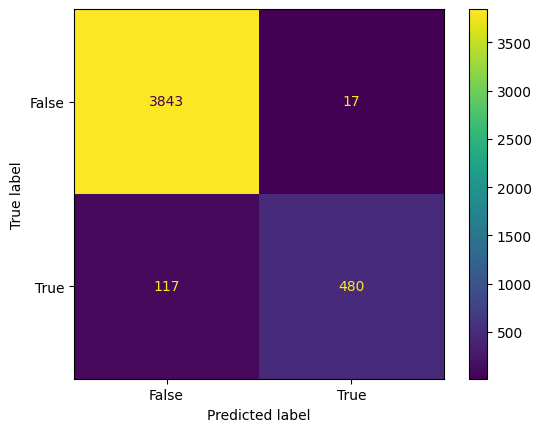

In [29]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h2>Confusion Matrix for test data</h2>

True Positive 115
True Negative 957
False Positive 8
False Negative 35


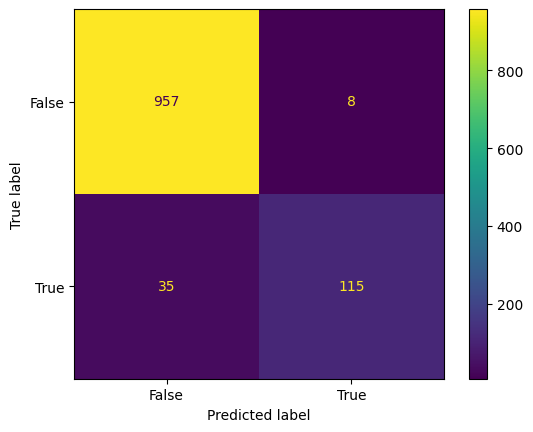

In [30]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h1>Dimension Reduction using Feature Selection</h1>

<h2>Method 1: Using Variance Threshold</h2>

This method removes all features whose variance does not meet the threshold. Simply, it removes features whose value is constant in p X 100% of the samples.

**threshold = variance = p(1-p)**

In [31]:
sel = VarianceThreshold(threshold=(0.000690 * (1-0.000690)))
reduced_X = sel.fit_transform(X)

In [32]:
reduced_X.shape

(5572, 1912)

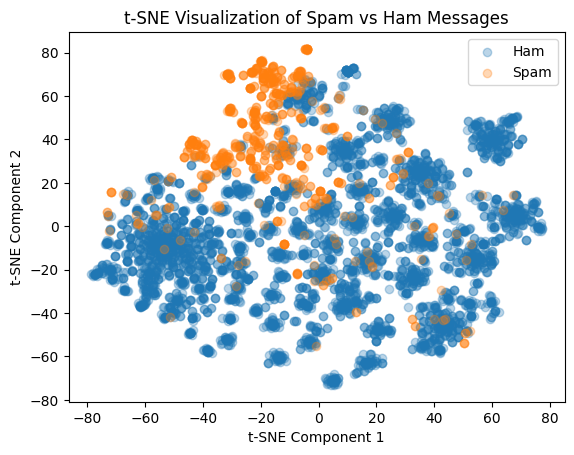

In [33]:
visualize_data(reduced_X)

<h3>Training and Evaluating our model</h3>

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

In [35]:
model.fit(X_train, Y_train)

LogisticRegression()

In [36]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.37
Accuracy on test data is: 97.94
F1 score on train data is: 0.98
F1 score on test data is: 0.92


<h3>Plotting our results</h3>

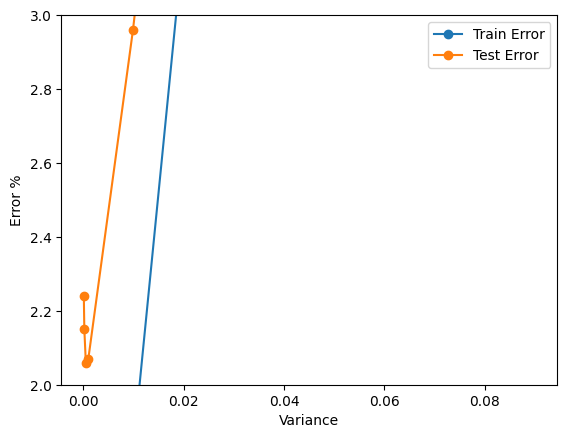

In [37]:
xpoints = np.array([0.00009999,0.00019996,0.00049975,0.000999,0.0099,0.09])
train_points = np.array([0.36,0.52,0.6,0.7,1.82,12.81])
test_points = np.array([2.24,2.15,2.06,2.07,2.96,12.47])
plt.xlabel("Variance")
plt.ylabel("Error %")

plt.plot(xpoints, train_points, marker='o', label="Train Error")
plt.plot(xpoints, test_points, marker='o', label="Test Error")
plt.ylim(2,3)
plt.legend()
plt.show()

<h3>Confusion Matrix for train data</h3>

True Positive 570
True Negative 3859
False Positive 1
False Negative 27


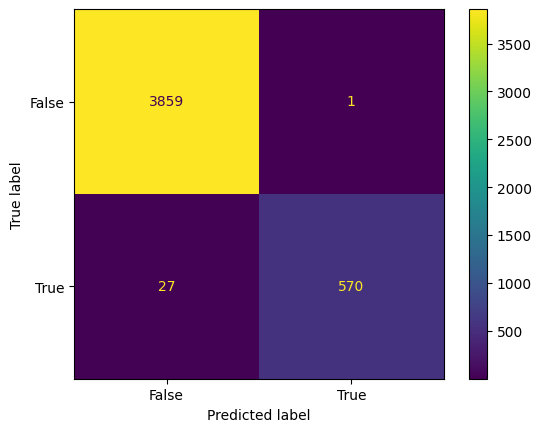

In [38]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 127
True Negative 965
False Positive 0
False Negative 23


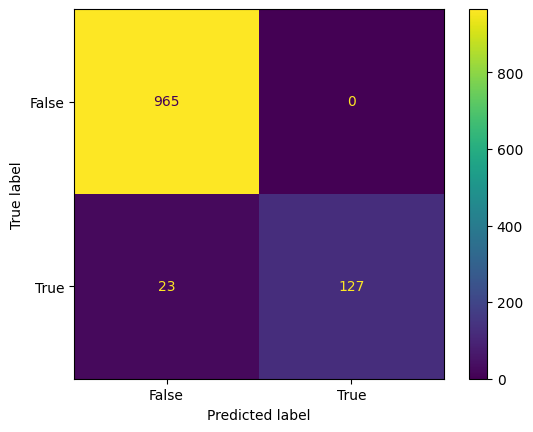

In [39]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h2>Method 2: Using Univariate Feature Selection (based on ANOVA F-Value)</h2>

It works by selecting the best features based on univariate statistical tests. SelectKBest select best k scoring features

In [40]:
selector = SelectKBest(f_classif, k=2000)
selector.fit(X,Y)

SelectKBest(k=2000)

In [41]:
reduced_X = selector.transform(X)
print(f"Reduction Performed. Result are:\nX: {X.shape} -> reduced_X: {reduced_X.shape}")

Reduction Performed. Result are:
X: (5572, 6221) -> reduced_X: (5572, 2000)


<h3>Visualising Reduced Data</h3>

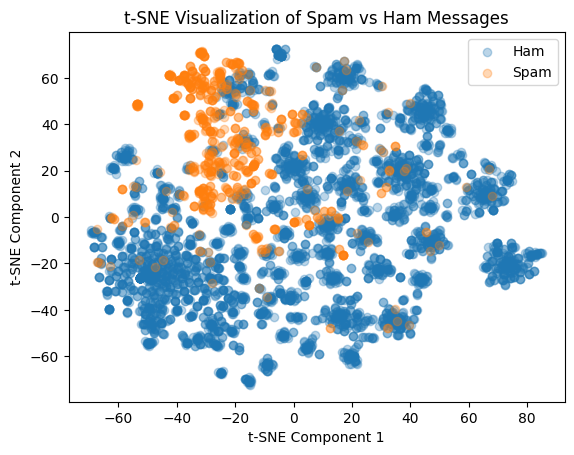

In [42]:
visualize_data(reduced_X)

<h3>Training and Evaluating our Model</h3>

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

In [44]:
model.fit(X_train, Y_train)

LogisticRegression()

In [45]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.46
Accuracy on test data is: 97.85
F1 score on train data is: 0.98
F1 score on test data is: 0.91


<h3>Plotting our results</h3>

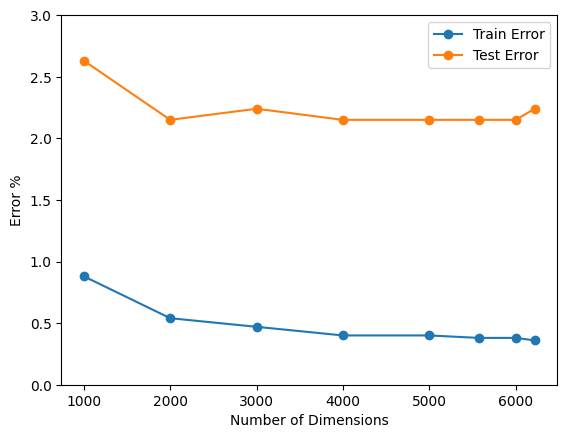

In [46]:
xpoints = np.array([1000,2000,3000,4000,5000,5572,6000,6221])
train_points = np.array([0.88,0.54,0.47,0.4,0.4,0.38,0.38,0.36])
test_points = np.array([2.63,2.15,2.24,2.15,2.15,2.15,2.15,2.24])
plt.xlabel("Number of Dimensions")
plt.ylabel("Error %")

plt.plot(xpoints, train_points, marker='o', label="Train Error")
plt.plot(xpoints, test_points, marker='o', label="Test Error")
plt.ylim(0,3)
plt.legend()
plt.show()

<h3>Confusion Matrix for train data</h3>

True Positive 574
True Negative 3859
False Positive 1
False Negative 23


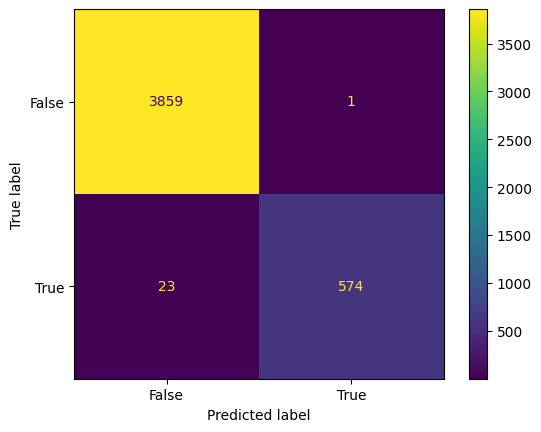

In [47]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 126
True Negative 965
False Positive 0
False Negative 24


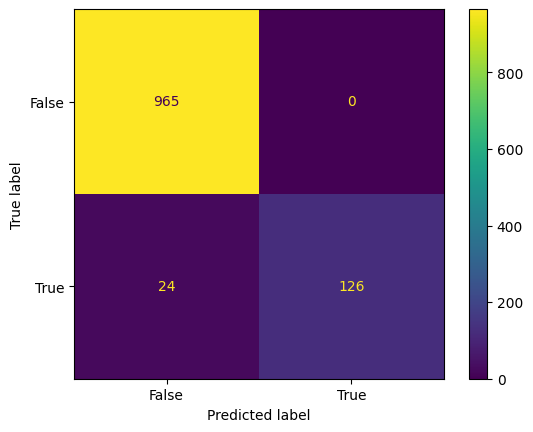

In [48]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h2>Method 3: Using Univariate Feature Selection (based on Chi Square)</h2>

In [50]:
selector = SelectKBest(chi2, k=2000)
selector.fit(X,Y)

SelectKBest(k=2000, score_func=<function chi2 at 0x00000205E2016520>)

In [51]:
reduced_X = selector.transform(X)
print(f"Reduction Performed. Result are:\nX: {X.shape} -> reduced_X: {reduced_X.shape}")

Reduction Performed. Result are:
X: (5572, 6221) -> reduced_X: (5572, 2000)


<h3>Visualising Reduced Data</h3>

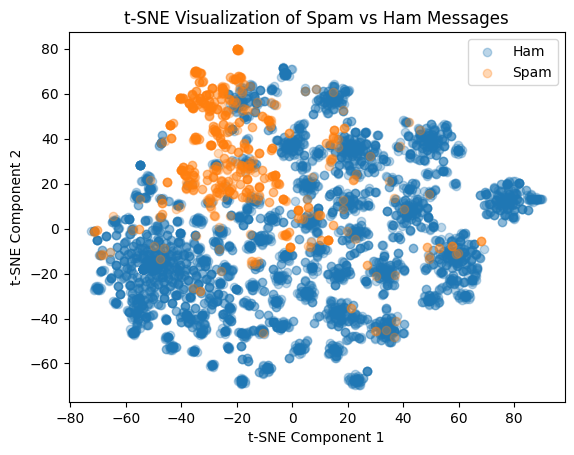

In [52]:
visualize_data(reduced_X)

<h3>Training and Evaluating our Model</h3>

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

In [54]:
model.fit(X_train, Y_train)

LogisticRegression()

In [55]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.48
Accuracy on test data is: 97.85
F1 score on train data is: 0.98
F1 score on test data is: 0.91


<h3>Plotting our results</h3>

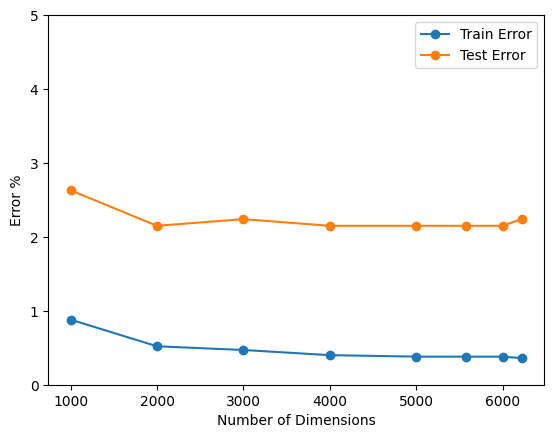

In [56]:
xpoints = np.array([1000,2000,3000,4000,5000,5572,6000,6221])
train_points = np.array([0.88,0.52,0.47,0.4,0.38,0.38,0.38,0.36])
test_points = np.array([2.63,2.15,2.24,2.15,2.15,2.15,2.15,2.24])
plt.xlabel("Number of Dimensions")
plt.ylabel("Error %")

plt.plot(xpoints, train_points, marker='o', label="Train Error")
plt.plot(xpoints, test_points, marker='o', label="Test Error")
plt.ylim(0,5)
plt.legend()
plt.show()

<h3>Confusion Matrix for train data</h3>

True Positive 574
True Negative 3860
False Positive 0
False Negative 23


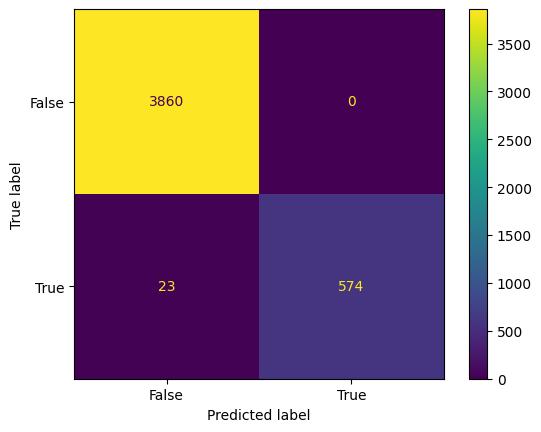

In [57]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 126
True Negative 965
False Positive 0
False Negative 24


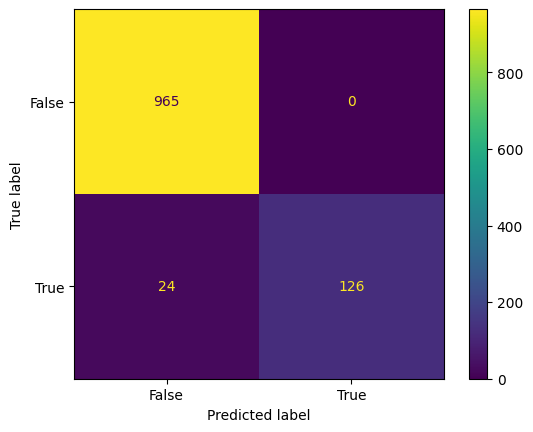

In [58]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h2>Method 4: Using Select From Model</h2>

In [59]:
selector = SelectFromModel(estimator=LogisticRegression(), prefit=False, threshold="median")
selector.fit(X,Y)

SelectFromModel(estimator=LogisticRegression(), threshold='median')

In [60]:
reduced_X = selector.transform(X)
print(f"Reduction Performed. Result are:\nX: {X.shape} -> reduced_X: {reduced_X.shape}")

Reduction Performed. Result are:
X: (5572, 6221) -> reduced_X: (5572, 3111)


<h3>Visualising Reduced Data</h3>

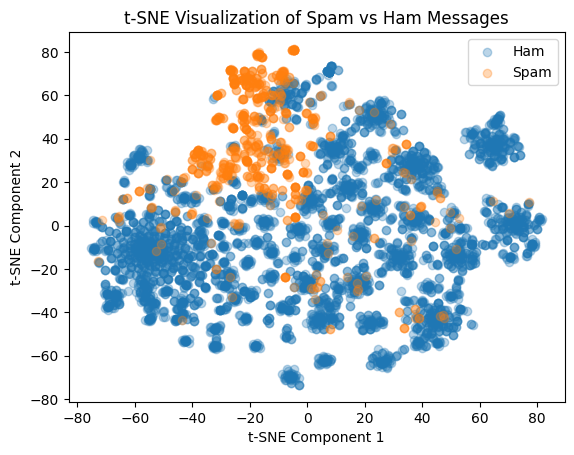

In [61]:
visualize_data(reduced_X)

<h3>Training and Evaluating our Model</h3>

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

In [63]:
model.fit(X_train, Y_train)

LogisticRegression()

In [64]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.64
Accuracy on test data is: 97.76
F1 score on train data is: 0.99
F1 score on test data is: 0.91


<h3>Confusion Matrix for train data</h3>

True Positive 582
True Negative 3859
False Positive 1
False Negative 15


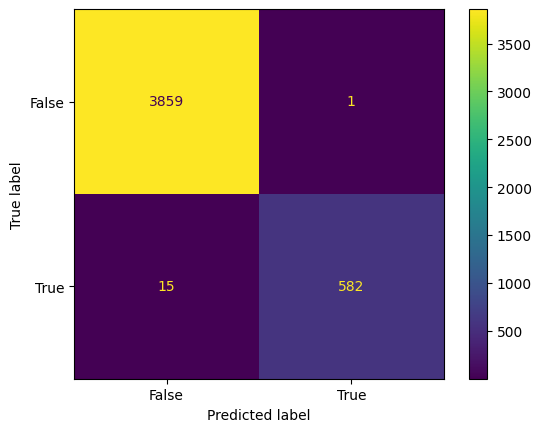

In [65]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 125
True Negative 965
False Positive 0
False Negative 25


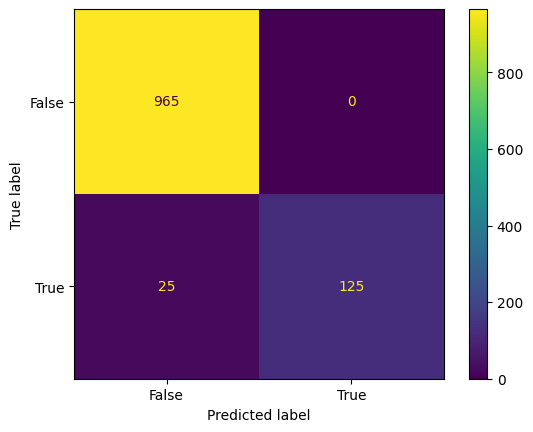

In [66]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h1>Dimension Reduction using Feature Projection</h1>

<h2>Method 1: Using Principal Component Analysis</h2>

In [67]:
selector = PCA(n_components = 2000)
selector.fit(X)

PCA(n_components=2000)

In [68]:
reduced_X = selector.transform(X)
print(f"Reduction Performed. Result are:\nX: {X.shape} -> reduced_X: {reduced_X.shape}")

Reduction Performed. Result are:
X: (5572, 6221) -> reduced_X: (5572, 2000)


<h3>Visualising Reduced Data</h3>

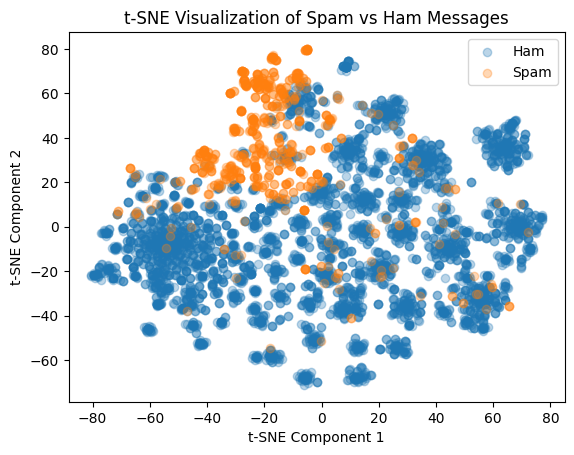

In [69]:
visualize_data(reduced_X)

<h3>Training and Evaluating our Model</h3>

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size = 0.20, random_state=42)

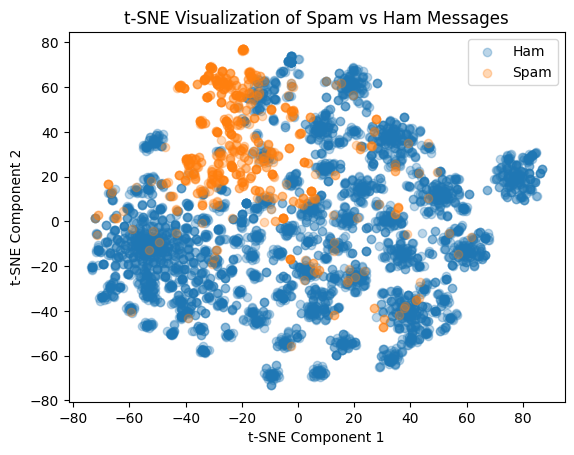

In [71]:
visualize_data(reduced_X)

In [72]:
model.fit(X_train, Y_train)

LogisticRegression()

In [73]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.48
Accuracy on test data is: 97.76
F1 score on train data is: 0.98
F1 score on test data is: 0.91


<h3>Confusion Matrix for train data</h3>

True Positive 575
True Negative 3859
False Positive 1
False Negative 22


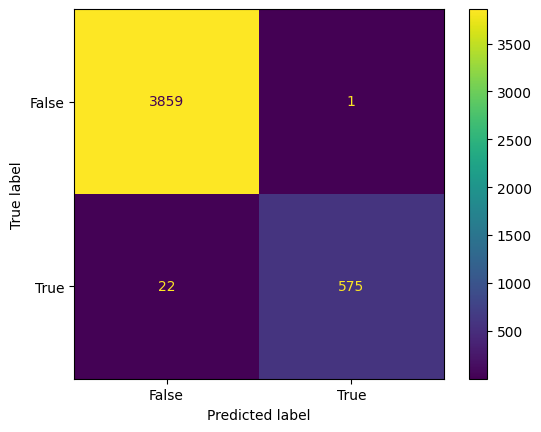

In [74]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 125
True Negative 965
False Positive 0
False Negative 25


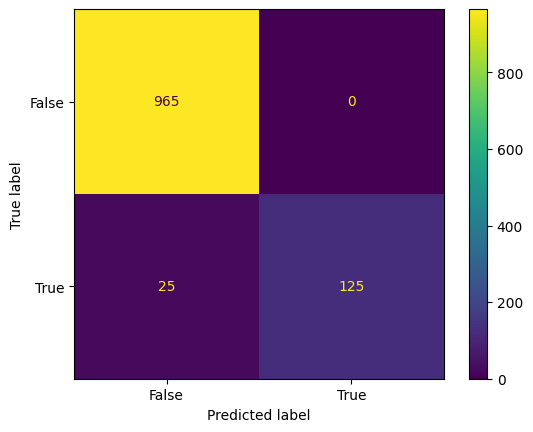

In [75]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)

<h2>Method 2: Linear Discriminant Analysis</h2>

In [76]:
selector = LinearDiscriminantAnalysis(n_components=None)
selector.fit(X,Y)

LinearDiscriminantAnalysis()

In [77]:
reduced_X = selector.transform(X)
print(f"Reduction Performed. Result are:\nX: {X.shape} -> reduced_X: {reduced_X.shape}")

Reduction Performed. Result are:
X: (5572, 6221) -> reduced_X: (5572, 1)


<h3>Training and Evaluating our Model</h3>

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size=0.2, random_state=42)

In [79]:
model.fit(X_train, Y_train)

LogisticRegression()

In [80]:
evaluate_model(model=model, train_set=(X_train,Y_train), test_set=(X_test,Y_test))

Accuracy on train data is: 99.96
Accuracy on test data is: 99.91
F1 score on train data is: 1.00
F1 score on test data is: 1.00


<h3>Confusion Matrix for train data</h3>

True Positive 596
True Negative 3859
False Positive 1
False Negative 1


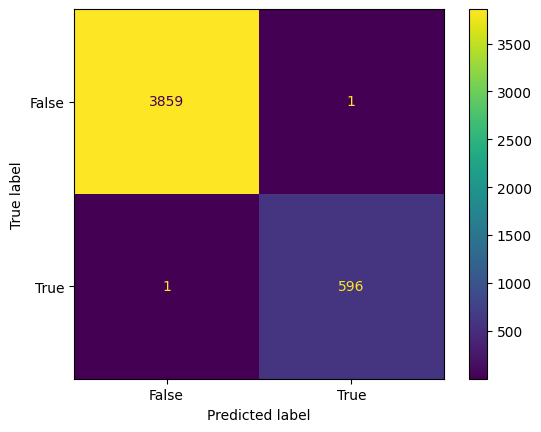

In [81]:
generate_confusion_matrix(data=X_train, labels=Y_train, model=model)

<h3>Confusion Matrix for test data</h3>

True Positive 150
True Negative 964
False Positive 1
False Negative 0


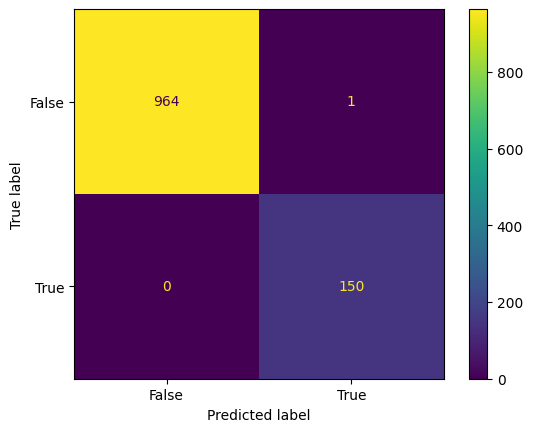

In [82]:
generate_confusion_matrix(data=X_test, labels=Y_test, model=model)